In [1]:
import os
os.chdir('/home/david/Projects/optogenetic_whole_cell_activation/morph_impact_on_opt_stim')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neurostim.polarmaps import simple_polar_map
from neurostim.cell import Cell
from neuron import h
import matplotlib as mpl
import numpy as np
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
# format
# dimensions (A4:  8.27 x 11.69 inches)
text_frac = 0.8
abs_pw = 8.27 # pagewidth
abs_pl = 11.69 # pagelength
pw = text_frac * abs_pw
pl = text_frac * abs_pl
# others
dpi=600

In [3]:
# cortical depth of neuron models
cortical_depth = {'L23': 400, 'L5': 1170} #um
# ChR2 expression distribution and level
chanrhod_distribution = 'uniform' 
chanrhod_soma_density = 13e9
# NEURON setup
h.load_file("stdrun.hoc")
h.cvode_active(1)
# load cell and create stimulation object
cell = Cell(
    hoc_file="simneurostim/model/hoc/L5.hoc",
    cortical_depth=cortical_depth,
    ChR_soma_density=chanrhod_soma_density,
    ChR_distribution=chanrhod_distribution
)
# function to label compartment type
def compartment_converter(seg):
    if 'ais' in str(seg):
        return 'soma/basal/axon'
    elif 'soma' in str(seg):
        return 'soma/basal/axon'
    elif 'dend11' in str(seg):
        if eval('h.'+str(seg)+'.z_chanrhod') > -300:
            return 'apical'
        elif eval('h.'+str(seg)+'.z_chanrhod') > -850:
            return 'apical shaft'
        elif eval('h.'+str(seg)+'.z_chanrhod') > -1100 and eval('h.'+str(seg)+'.x_chanrhod')**2+eval('h.'+str(seg)+'.y_chanrhod')**2 < 170:
            return 'apical shaft'
        else:
            return 'soma/basal/axon'
    elif 'dend' in str(seg):
        return 'soma/basal/axon'
    elif 'myelin' in str(seg):
        return 'soma/basal/axon'
    elif 'nakeaxon' in str(seg):
        return 'soma/basal/axon'
    elif 'node' in str(seg):
        return 'soma/basal/axon'
    elif 'hill' in str(seg):
        return 'soma/basal/axon'
    else:
        return 'None'

	1 
	1 
	1 
	1 


In [4]:
data = pd.read_hdf('data/conductances/all_data.hdf')
# reduce fixed params
neuron='L5'
light_model='foutz_et_al2012'
ChRdistrib = 'uniform'
ChRexpression=13e9
fiber_d=200
fiber_NA=0.22
stim_duration=200
data = data.loc[neuron,light_model,ChRdistrib,ChRexpression,fiber_d,fiber_NA,stim_duration]

In [5]:
data['seglabel'] = [compartment_converter(seg) for seg in data.reset_index().segname]

In [6]:
data

mean_conductance_pS  \
light_power radius [um] angle [rad] segname                             
0.00005     0           0.000000    ais[0](0.05)         3.265252e-02   
                                    ais[0](0.15)         3.227652e-02   
                                    ais[0](0.25)         3.184991e-02   
                                    ais[0](0.35)         3.142432e-02   
                                    ais[0](0.45)         3.099976e-02   
...                                                               ...   
0.00500     975         5.890486    soma(0.55)           4.467907e-08   
                                    soma(0.65)           4.837660e-08   
                                    soma(0.75)           5.157106e-08   
                                    soma(0.85)           4.601176e-08   
                                    soma(0.95)           2.987511e-08   

                                                  AP_count         seglabel  
light_power radius [um] angle [rad] segname                                  
0.00005     0           0.000000    ais[0](0.05)         0  soma/basal/axon  
                                    ais[0](0.15)         0  soma/basal/axon  
                                    ais[0](0.25)         0  soma/basal/axon  
                                    ais[0](0.35)         0  soma/basal/axon  
                                    ais[0](0.45)         0  soma/basal/axon  
...                                                    ...              ...  
0.00500     975         5.890486    soma(0.55)           0  soma/basal/axon  
                                    soma(0.65)           0  soma/basal/axon  
                                    soma(0.75)           0  soma/basal/axon  
                                    soma(0.85)           0  soma/basal/axon  
                                    soma(0.95)           0  soma/basal/axon  

[1603200 rows x 3 columns]

In [7]:
max_g_comp = pd.DataFrame(
    data.groupby(['light_power','radius [um]','angle [rad]']
                )['mean_conductance_pS','AP_count'].max())

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
seglabels = []
for lp,radius,angle in zip(max_g_comp.reset_index()['light_power'],max_g_comp.reset_index()['radius [um]'],max_g_comp.reset_index()['angle [rad]']):
    seglabels.append(data.loc[lp, radius, angle].loc[data.loc[lp, radius, angle].mean_conductance_pS==max_g_comp.loc[lp,radius,angle].mean_conductance_pS].seglabel)

In [9]:
max_g_comp['seglabel'] = [seglabel.values[0] for seglabel in seglabels]

In [10]:
max_g_comp = max_g_comp.reset_index().set_index(['light_power','radius [um]','angle [rad]','seglabel'])

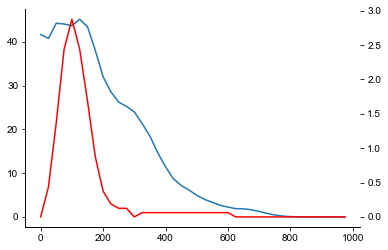

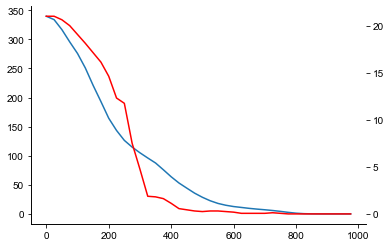

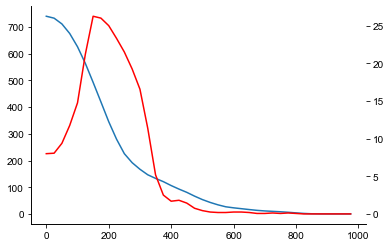

In [21]:
# plot radial profiles of max conductance and AP_count
for  lp in [0.00005, 0.001, 0.005]:
    plot_df = max_g_comp.loc[lp,:,].groupby(['radius [um]']).mean().reset_index()
    plt.plot(plot_df['radius [um]'].values, plot_df['mean_conductance_pS'].values)
    plt.gca().twinx().plot(plot_df['radius [um]'].values, plot_df['AP_count'].values,c='red')
    plt.show()

In [22]:
max_g_comp.loc[max_g_comp.mean_conductance_pS<0.1]==np.nan
pivot = max_g_comp.reset_index().pivot(index=['light_power', 'radius [um]', 'angle [rad]'], columns = 'seglabel', values='mean_conductance_pS')

In [23]:
colors.rgb2hex(Purples(254))

NameError: name 'colors' is not defined

In [64]:

colors.rgb2hex(Purples(150.))

'#3f007d'

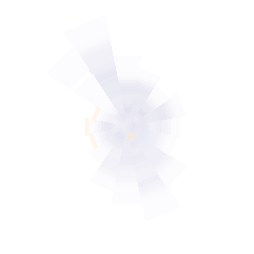

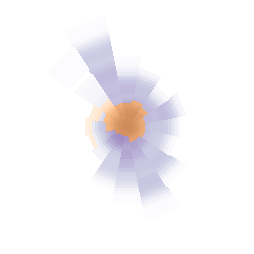

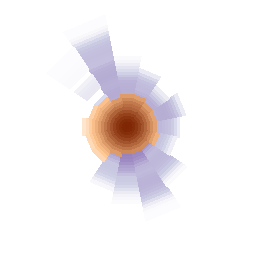

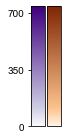

In [24]:
from matplotlib.cm import Blues
from matplotlib.cm import Purples
from matplotlib.cm import Oranges
from matplotlib import colors

#### create custom colormaps ######
#colors_custom1 = [(0, '#ffffff'), (0.15, '#d2b8e6'), (1, '#4e008e')] #the second value (0.15) controls the colorbar speed at low values
colors_custom1 = [(0, colors.rgb2hex(Purples(0))), (0.15, colors.rgb2hex(Purples(int(0.3*255)))), (1, colors.rgb2hex(Purples(255)))]
#colors_custom1 = [(0, colors.rgb2hex(Purples(0))), (0.5, colors.rgb2hex(Purples(int(0.5*255)))), (1, '#000000')]
custom_Purples = colors.LinearSegmentedColormap.from_list('CustomPurples', colors_custom1)

#colors_custom2 = [(0, '#ffffff'), (0.15, '#f9c99f'), (1, '#ff4500')]
colors_custom2 = [(0, colors.rgb2hex(Oranges(0))), (0.15, colors.rgb2hex(Oranges(int(0.3*255)))), (1, colors.rgb2hex(Oranges(255)))]
#colors_custom2 = [(0, colors.rgb2hex(Oranges(0))), (0.5, colors.rgb2hex(Oranges(int(0.5*255)))), (1, '#000000')] #the second value (0.15) controls the colorbar speed at low values
custom_Oranges = colors.LinearSegmentedColormap.from_list('CustomOranges', colors_custom2)

max_cond = max_g_comp.loc[5e-3].mean_conductance_pS.max()
#max_cond=350

for lp in [5e-5, 1e-3, 5e-3]:
    #max_cond = max_g_comp.loc[lp].mean_conductance_pS.max()
    fig = plt.figure(constrained_layout=False, figsize=(pw/1.5,pw/1.5))
    gs = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.95,
                            wspace=0.05)
    ax = fig.add_subplot(gs[0,0], projection="polar")
    ax, mappable1 = simple_polar_map(
        data=pd.DataFrame(pivot['apical']).loc[lp,:,:].reset_index(),
        plot_col='apical',
        cmap= custom_Purples,
        ax=ax,
        vmin=0,
        vmax=max_cond)
    ax, mappable2 = simple_polar_map(
        data=pd.DataFrame(pivot['apical shaft']).loc[lp,:,:].reset_index(),
        plot_col='apical shaft',
        cmap= custom_Oranges,
        ax=ax,
        vmin=0,
        vmax=max_cond)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.grid()
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/lead_conductance_map_'+str(lp)+'.png', dpi=dpi, 
                facecolor='w', edgecolor='w',  
                bbox_inches='tight')
    plt.show()
############# absolute scale
fig = plt.figure(figsize=(pw/8,pw/3))
ax = fig.add_subplot(131)
plt.colorbar(mappable1,cax=ax,ticks=[0,350,700])
ax.yaxis.set_ticks_position('left')
ax2 = fig.add_subplot(132)
plt.colorbar(mappable2,cax=ax2,ticks=[])

fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/triple_cbar_absolute.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

In [25]:
Oranges(0)

(1.0, 0.9607843137254902, 0.9215686274509803, 1.0)

In [26]:
np.array(custom_Oranges(1)) - np.array(Oranges(1))

array([-8.20197360e-05, -3.28078944e-03, -6.06946046e-03,  0.00000000e+00])

In [27]:
max_cond

740.6045555716189

In [28]:
max_g_comp.loc[1e-3].mean_conductance_pS.max()

339.83365592477156

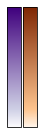

In [30]:
fig = plt.figure(figsize=(pw/8,pw/3))
ax = fig.add_subplot(131)
plt.colorbar(mappable1,cax=ax,ticks=[])
ax2 = fig.add_subplot(132)
plt.colorbar(mappable2,cax=ax2,ticks=[])
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/triple_cbar_normalized.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()


In [42]:
print(colors.rgb2hex(Oranges(1)))

#fff5ea


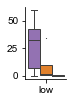

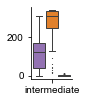

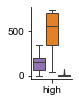

In [31]:
# transition from light energy to conductance
# plot ChR cond for each compartment dep on light energy absorbed by compartment
common_hue_order = ['apical','apical shaft','soma/basal/axon']
palette = ['tab:purple','tab:orange','tab:blue']
light_powers = [5e-5, 1e-3, 5e-3]
for lp,xticklabel in zip(light_powers,['low','intermediate','high']):
    fig, ax = plt.subplots(figsize=(pw/9,pw/5))
    sns.boxplot(
        #data=cond_light_energy_merged.loc[lp],
        data=max_g_comp.loc[lp,:,:,:].reset_index(),
        x='light_power', y='mean_conductance_pS', hue='seglabel', hue_order=common_hue_order, palette=palette, ax=ax, 
        fliersize=0.3, linewidth=1, width=0.9,
        dodge=True,
    )
    ax.get_legend().remove()
    ax.set_xticklabels([xticklabel])
    #plt.ylim(0,None)
    #plt.xlim(0,None)
    plt.xlabel('')
    plt.ylabel('')
    fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/leading_conductance_box_'+str(lp)+'.png', dpi=dpi, 
                facecolor=None, edgecolor=None,  
                bbox_inches='tight')
    plt.show()

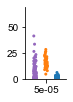

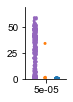

In [32]:
# plot conductance for all compartments in a box for one fiber position
fig, ax = plt.subplots(figsize=(pw/9,pw/5))
sns.stripplot(
    data=data.loc[5e-5,0,0,:].reset_index(),
    x='light_power', y='mean_conductance_pS', hue='seglabel', hue_order=common_hue_order, palette=palette, ax=ax, 
    s=3,
    #fliersize=0.3, linewidth=1, width=0.9, whis=100,
    dodge=True,
)
ax.get_legend().remove()
#ax.set_xticklabels([xticklabel])
plt.ylim(0,70)
#plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/cond_comps_central_stim_position_low_light_power_scatter_largedata.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()
# plot max conductance across compartments in a box for all fiber positions
fig, ax = plt.subplots(figsize=(pw/9,pw/5))
sns.stripplot(
    data=max_g_comp.loc[5e-5,:,:,:].reset_index(),
    x='light_power', y='mean_conductance_pS', hue='seglabel', hue_order=common_hue_order, palette=palette, ax=ax, 
    s=3,
    #fliersize=0.3, linewidth=1, width=0.9, whis=100,
    dodge=True,
)
ax.get_legend().remove()
#ax.set_xticklabels([xticklabel])
plt.ylim(0,70)
#plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/leading_cond_all_stim_positions_low_light_power_scatter.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

In [62]:
Greys(1)

(0.9981545559400231, 0.9981545559400231, 0.9981545559400231, 1.0)

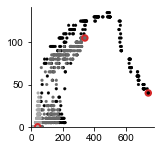

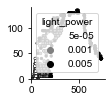

In [72]:
from matplotlib.cm import Greys
# transition from conductance into neural response
# plot neural response dep on maximal ChR conductance across compartments
fig, ax = plt.subplots(figsize=(pw/3,pw/3))
dfplot = max_g_comp.loc[:,:,:,:][::-1]
# convert APC to spikes (multiply by 5 since 200 ms stim duration)
dfplot['fr'] = dfplot['AP_count'] * 5 
sns.scatterplot(
    data=dfplot,
    x='mean_conductance_pS', y='fr', hue='light_power', hue_order=[0.00005, 0.001, 0.005],
    palette=['darkgrey','dimgrey','black'], 
    edgecolor=None,
    ax=ax, s=8, legend=False
)
# mark central stimulator positions
dfplot = max_g_comp.loc[:,0,0,:][::-1]
dfplot['fr'] = dfplot['AP_count'] * 5 
sns.scatterplot(
    data=dfplot,
    x='mean_conductance_pS', y='fr', hue='light_power', hue_order=[0.00005, 0.001, 0.005],
    palette=['darkgrey','dimgrey','black'], 
    edgecolor='tab:red', linewidth=2,
    ax=ax, s=30, legend=False
)
plt.ylim(0,None)
plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='stimulation intensity', labels=['low','intermediate','high'])
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans2_neural_resp_max_cond_comp_ALL_Large_data.png', dpi=dpi, 
            facecolor=None, edgecolor=None, transparent=True, 
            bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(pw/5,pw/5))
dfplot = max_g_comp.loc[:,:,:,:][::-1]
# convert APC to spikes (multiply by 5 since 200 ms stim duration)
dfplot['fr'] = dfplot['AP_count'] * 5 
sns.scatterplot(
    data=dfplot,
    x='mean_conductance_pS', y='fr', hue='light_power', hue_order=[0.00005, 0.001, 0.005], palette=['white','grey','black'], edgecolor='black', linewidth=0.5, 
    ax=ax, s=8, legend='brief'
)
plt.ylim(0,None)
plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='stimulation intensity', labels=['low','intermediate','high'])
#fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans2_neural_resp_max_cond_comp_ALL_Large_data_with_legend.svg', dpi=dpi, 
#            facecolor=None, edgecolor=None,  
#            bbox_inches='tight')
plt.show()

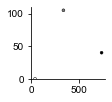

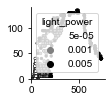

In [35]:
# transition from conductance into neural response
# plot neural response dep on maximal ChR conductance across compartments
fig, ax = plt.subplots(figsize=(pw/5,pw/5))
dfplot = max_g_comp.loc[:,0,0,:][::-1]
# convert APC to spikes (multiply by 5 since 200 ms stim duration)
dfplot['fr'] = dfplot['AP_count'] * 5 
sns.scatterplot(
    data=dfplot,
    x='mean_conductance_pS', y='fr', hue='light_power', hue_order=[0.00005, 0.001, 0.005], palette=['white','grey','black'], edgecolor='black', linewidth=0.5, 
    ax=ax, s=8, legend=False
)
plt.ylim(0,None)
plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='stimulation intensity', labels=['low','intermediate','high'])
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans2_neural_resp_max_cond_comp_ALL_Large_data.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(pw/5,pw/5))
dfplot = max_g_comp.loc[:,:,:,:][::-1]
# convert APC to spikes (multiply by 5 since 200 ms stim duration)
dfplot['fr'] = dfplot['AP_count'] * 5 
sns.scatterplot(
    data=dfplot,
    x='mean_conductance_pS', y='fr', hue='light_power', hue_order=[0.00005, 0.001, 0.005], palette=['white','grey','black'], edgecolor='black', linewidth=0.5, 
    ax=ax, s=8, legend='brief'
)
plt.ylim(0,None)
plt.xlim(0,None)
plt.xlabel('')
plt.ylabel('')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='stimulation intensity', labels=['low','intermediate','high'])
fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans2_neural_resp_max_cond_comp_ALL_Large_data_with_legend.svg', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

In [19]:
# transition from conductance into neural response
# plot neural response dep on maximal ChR conductance across compartments
for lp in light_powers:
    fig, ax = plt.subplots(figsize=(pw/3,pw/5))
    dfplot = max_g_comp.loc[lp]
    # convert APC to spikes (multiply by 5 since 200 ms stim duration)
    dfplot['AP_count'] = dfplot['AP_count'] * 5 
    sns.scatterplot(
        data=dfplot,
        x='mean_conductance_pS', y='AP_count', hue='light_power', palette=['white',,
        ax=ax, legend=False
    )
    plt.ylim(0,None)
    plt.xlim(0,None)
    plt.xlabel('')
    plt.ylabel('')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='stimulation intensity', labels=['low','intermediate','high'])
    #fig.savefig('paper/NEW_FIGURES/NEWFIG4_spatial_profs_reason/plots/trans2_neural_resp_max_cond_comp_ALL.png', dpi=dpi, 
    #            facecolor=None, edgecolor=None,  
    #            bbox_inches='tight')
    plt.show()

SyntaxError: invalid syntax (<ipython-input-19-c435492af7b1>, line 10)